In [1]:
import os
import numpy as np
from scipy.misc import imsave
import keras.backend as K
from scipy.optimize import fmin_l_bfgs_b

def limit_mem():
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))
limit_mem()

Using TensorFlow backend.


In [2]:
data_path = '/home/bfortuner/workplace/data/'
images_path = data_path+'imagenet_sample/'
styles_path = data_path+'styles/'
results_path = data_path+'neural_style_results/'
style_img_path = styles_path+"starrynight.jpg"

### Get Images

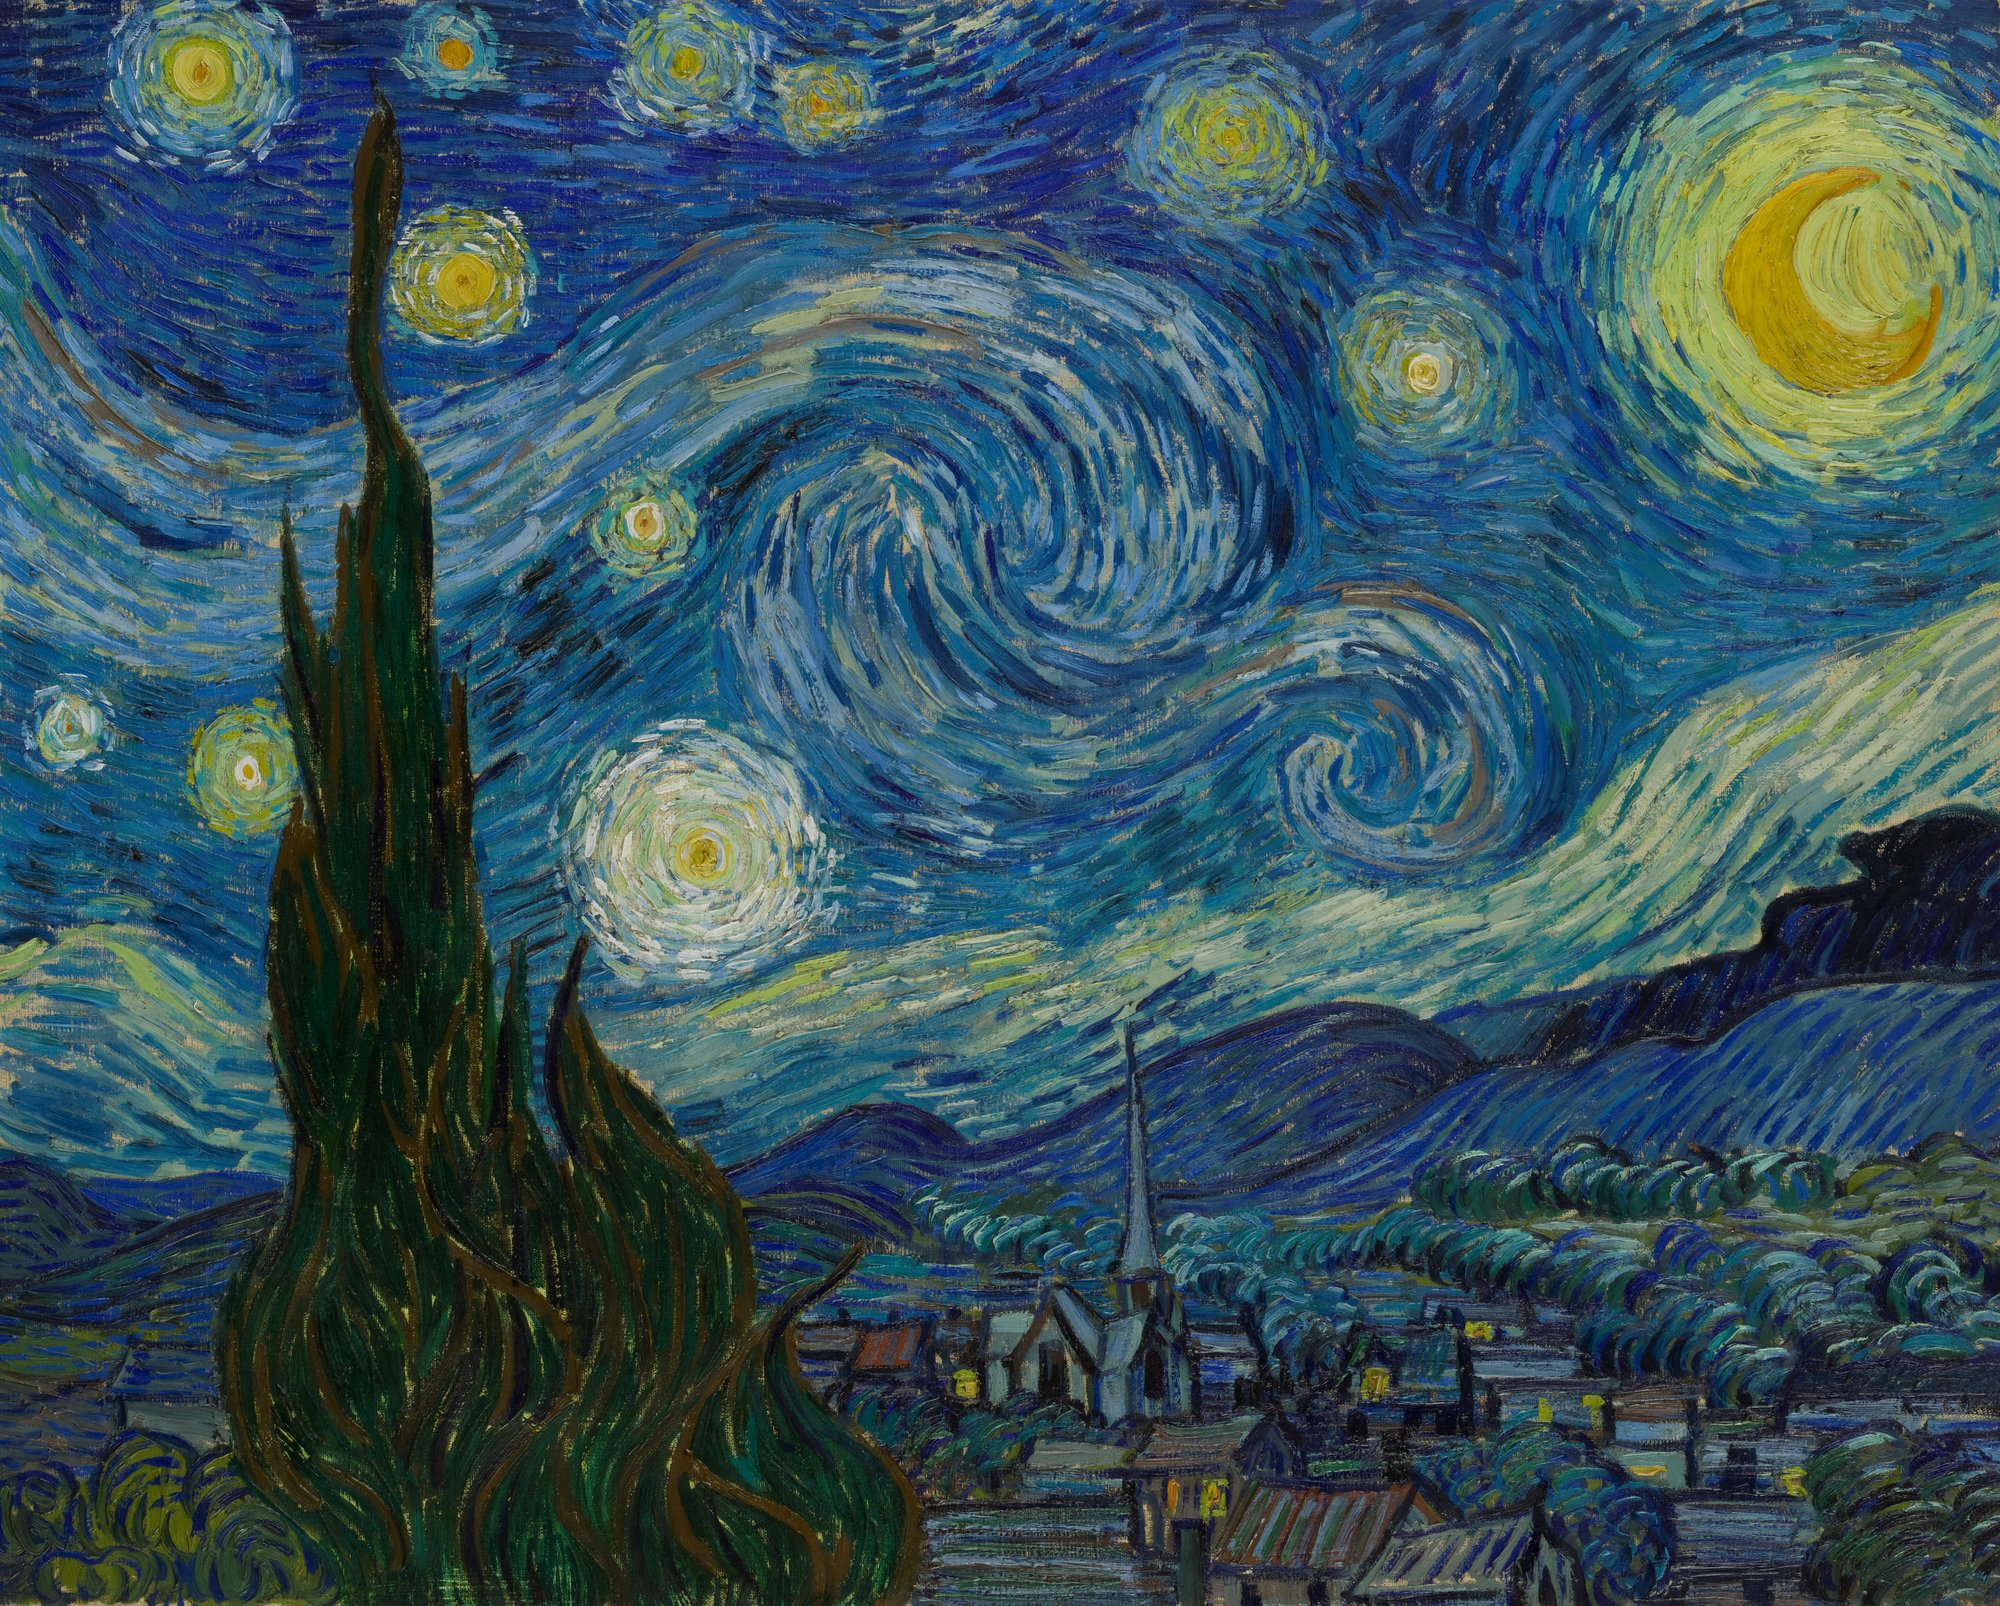

In [77]:
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
import random

def get_paths_to_files(dir_path):
    filepaths = []
    for (dirpath, dirnames, filenames) in os.walk(dir_path):
        filepaths.extend(os.path.join(dirpath, f) for f in filenames)
    return filepaths

def get_random_image_path(dir_path):
    filepaths = get_paths_to_files(dir_path) 
    return filepaths[random.randrange(len(filepaths))] 

def get_random_image(dir_path):
    filepaths = get_paths_to_files(dir_path) 
    return load_img(filepaths[random.randrange(len(filepaths))]) 

def get_volume_dims_as_integers(volume):
    integer_dims = []
    for dim in volume.shape.dims:
        integer_dims.append(dim.value)
    return integer_dims

get_random_image(images_path)
load_img(style_img_path)

### Initialize VGG

In [30]:
from keras.applications import vgg16

def get_vgg(input_tensor):
    return vgg16.VGG16(input_tensor=input_tensor,
            weights='imagenet', include_top=False)

### Hyperparameters

In [8]:
content_loss_weight = .5
style_loss_weight = .5
#total_variation_weight?

### Preprocess Images

VGG authors preprocessed their images. We subtract the mean of each channel of the imagenet data and reverse the order of RGB->BGR since those are the preprocessing steps that the VGG authors did - so their model won't work unless we do the same thing.

Keras VGG has a nice preprocess step for us, but we need to implement the deprocess.

In [13]:
content_img_path = get_random_image_path(images_path)
style_img = load_img(style_img_path)

print (content_img_path)
print(style_img.size)

/home/bfortuner/workplace/data/imagenet_sample/n03272010/n03272010_1938.JPEG
(2000, 1606)


In [25]:
import matplotlib.pyplot as plt

def get_output_image_dims(image_path):
    width, height = load_img(image_path).size
    img_nrows = 400
    img_ncols = int(width * img_nrows / height)
    return img_nrows, img_ncols

def preprocess_image(image_path, target_rows, target_cols):
    img = load_img(image_path, target_size=(target_rows, target_cols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

def deprocess_image(img_vol, target_rows, target_cols):
    img_vol = img_vol.reshape((target_rows, target_cols, 3))
    # Remove zero-center by mean pixel
    img_vol[:, :, 0] += 103.939
    img_vol[:, :, 1] += 116.779
    img_vol[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    img_vol = img_vol[:, :, ::-1]
    img_vol = np.clip(img_vol, 0, 255).astype('uint8')
    return img_vol

def get_image_volume(image_path, target_rows, target_cols):
    img_arr = preprocess_image(image_path, target_rows, target_cols)
    return K.variable(img_arr) #Tensor

    
# def plot_image_arr(arr):
#     plt.imshow(deprocess_image(arr,arr.shape[0],arr.shape[1]))


target_rows,target_cols = get_output_image_dims(content_img_path)
print(target_rows,target_cols)

img = load_img(content_img_path, target_size=(target_rows, target_cols))
img_a = img_to_array(img)
print (img_a)

content_img_vol = preprocess_image(content_img_path, target_rows, target_cols)
print (content_img_vol)

output_image = deprocess_image(content_img_vol, target_rows, target_cols)
print (output_image)
print (output_image.shape)

400 266
[[[  88.  122.  160.]
  [  90.  124.  162.]
  [  89.  123.  161.]
  ..., 
  [ 170.  190.  201.]
  [ 166.  185.  200.]
  [ 161.  180.  195.]]

 [[  88.  122.  159.]
  [  89.  123.  160.]
  [  88.  122.  159.]
  ..., 
  [ 169.  188.  202.]
  [ 163.  182.  197.]
  [ 158.  177.  192.]]

 [[  89.  121.  159.]
  [  91.  123.  161.]
  [  89.  123.  160.]
  ..., 
  [ 163.  182.  196.]
  [ 157.  176.  190.]
  [ 156.  173.  189.]]

 ..., 
 [[ 209.  197.  175.]
  [ 209.  196.  177.]
  [ 210.  197.  180.]
  ..., 
  [ 119.  102.   82.]
  [ 118.  100.   80.]
  [ 117.  100.   80.]]

 [[ 222.  209.  192.]
  [ 222.  209.  192.]
  [ 220.  211.  194.]
  ..., 
  [ 112.   95.   75.]
  [ 116.   98.   78.]
  [ 117.   99.   79.]]

 [[ 217.  201.  185.]
  [ 213.  200.  183.]
  [ 211.  204.  186.]
  ..., 
  [ 120.  103.   83.]
  [ 122.  104.   84.]
  [ 124.  103.   84.]]]
[[[[ 56.06099701   5.22100067 -35.68000031]
   [ 58.06099701   7.22100067 -33.68000031]
   [ 57.06099701   6.22100067 -34.68000031]
 

### Get Image, Style, Noise Volume

In [71]:
content_img_path = get_random_image_path(images_path)
style_img = load_img(style_img_path)

img_nrows,img_ncols = get_output_image_dims(content_img_path)

content_img_vol = get_image_volume(content_img_path, img_nrows, img_ncols)
style_img_vol = get_image_volume(style_img_path, img_nrows, img_ncols)
output_img_vol = K.placeholder((1, img_nrows, img_ncols, 3))
print (output_img_vol.shape)
dimensions = output_img_vol.shape.dims
type(dimensions[1])


from tensorflow import Dimension #tensorflow.python.framework.tensor_shape.Dimension
d = Dimension(2)
d.value

(1, 400, 735, 3)


In [31]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([content_img_vol,
                              style_img_vol,
                              output_img_vol], axis=0)

In [32]:
vgg_model = get_vgg(input_tensor)

In [45]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layers_dict = dict([(layer.name, layer.output) for layer in vgg_model.layers])
layers_dict

{'block1_conv1': <tf.Tensor 'Relu:0' shape=(3, 400, 600, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'Relu_1:0' shape=(3, 400, 600, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'MaxPool:0' shape=(3, 200, 300, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'Relu_2:0' shape=(3, 200, 300, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'Relu_3:0' shape=(3, 200, 300, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'MaxPool_1:0' shape=(3, 100, 150, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'Relu_4:0' shape=(3, 100, 150, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'Relu_5:0' shape=(3, 100, 150, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'Relu_6:0' shape=(3, 100, 150, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'MaxPool_2:0' shape=(3, 50, 75, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'Relu_7:0' shape=(3, 50, 75, 512) dtype=float32>,
 'block4_conv2': <tf.Tensor 'Relu_8:0' shape=(3, 50, 75, 512) dtype=float32>,
 'block4_conv3': <tf.Tensor 'Relu_9:0' shape=(3

### Gram Matrix 

In [35]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

### Style Loss

In [87]:
conv_layer_names = ['block1_conv1', 'block2_conv1',
              'block3_conv1', 'block4_conv1',
              'block5_conv1']
    
def style_loss(style_vol, output_vol, img_nrows, img_ncols):
    assert K.ndim(style_vol) == 3
    assert K.ndim(output_vol) == 3
    S = gram_matrix(style_vol)
    C = gram_matrix(output_vol)
    channels = 3
    img_dims = get_volume_dims_as_integers(output_vol)
    img_nrows,img_ncols = img_dims[1],img_dims[2]
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def get_style_loss(conv_layer_names, img_nrows, img_ncols, style_weight=1.0):
    loss = K.variable(0.)
    for layer_name in conv_layer_names:
        layer = layers_dict[layer_name]
        style_activation = layer[1, :, :, :]
        output_activation = layer[2, :, :, :]
        sl = style_loss(style_activation, output_activation, img_nrows, img_ncols)
        loss += (style_weight / len(conv_layer_names)) * sl
    return loss

get_style_loss(conv_layer_names, 400, 400)

<tf.Tensor 'add_33:0' shape=() dtype=float32>

### Content Loss

In [88]:
def content_loss(content_vol, output_vol):
    return K.sum(K.square(output_vol - content_vol))

def get_content_loss(layer_activations, content_weight=.025):
    content_activation = layer_activations[0, :, :, :]
    output_activation = layer_activations[2, :, :, :]
    return content_weight * content_loss(content_activation,
                                      output_activation)

loss = K.variable(0.)
layer_activations = layers_dict['block4_conv2']
get_content_loss(layer_activations)

<tf.Tensor 'mul_22:0' shape=() dtype=float32>

### Total Variation Loss

In [92]:
def total_variation_loss(x, img_nrows, img_ncols, variation_weight=1.0):
    assert K.ndim(x) == 4
    a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25)) * variation_weight

### Total Loss (Combined)

img_nrows, img_ncols = get_output_image_dims(content_img_path)
content_img_vol = get_image_volume(content_img_path, img_nrows, img_ncols)
style_img_vol = get_image_volume(style_img_path, img_nrows, img_ncols)
output_img_vol = K.placeholder((1, img_nrows, img_ncols, 3))

output_layer_activations = layers_dict['block4_conv2']
content_loss = get_content_loss(output_layer_activations)
style_loss = get_style_loss(conv_layer_names, img_nrows, img_ncols)
variation_loss = total_variation_loss(output_img_vol, img_nrows, img_ncols)

total_loss = style_loss + content_loss + variation_loss
print (total_loss.value)

### Gradient Descent

In [101]:
grads = K.gradients(total_loss, output_img_vol)

In [102]:
grads

[None]

In [103]:
outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([output_img_vol], outputs)


TypeError: Can not convert a NoneType into a Tensor or Operation.

In [104]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

### Scipy Evaluator 

In [105]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

### Train

In [107]:
import time
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = np.random.uniform(0, 255, (1, img_nrows, img_ncols, 3)) - 128.
iterations = 1
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0


NameError: name 'f_outputs' is not defined